In [1]:
import manage_gpus as gpl

gpl.get_gpu_lock(gpu_device_id=0, soft=True)

0

In [2]:
import pandas as pd

from encoder.utils import convert_audio
import torchaudio
import torch
from decoder.pretrained import WavTokenizer
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
import IPython.display as ipd

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
config_path = "./configs/wavtokenizer_mediumdata_frame75_3s_nq1_code4096_dim512_kmeans200_attn.yaml"
model_path = "/data/anasynth_nonbp/dtorres/wav_tokenizer/checkpoints/wavtokenizer_medium_speech_320_24k_v2.ckpt"

wavtokenizer = WavTokenizer.from_pretrained0802(config_path, model_path)
wavtokenizer = wavtokenizer.to(device)

/data/anasynth_nonbp/manaconda3/envs/tf2.14/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [29]:
codes = torch.tensor([2754, 3568, 1883, 1883, 3568, 1883, 3568, 3568, 3568, 3568, 3568,
        3568, 3568, 1883, 1300, 4031,  959, 3466, 1473, 3251,  893, 1700, 1887,
        2731, 1436, 2643, 2145,  858, 3772, 3772, 3712,  771, 3997,  657, 3065,
        2810, 3409,  398, 1915, 1257, 2945,  608, 3912,  852, 1667, 1950, 2140,
        1532, 3900, 2517, 3998, 3513, 2118, 2878,  705, 2839, 3050, 2375, 3453,
        2669, 3186, 1541, 1593, 3833,  881, 2531,  114, 1992,  666, 1483,   93,
        3478,  569,   88, 1652, 2176, 1359,  708, 2555, 1106,  477, 3673, 2723,
        2721, 1717, 3349,  787,  787,  712, 4010, 3794, 3230, 2620,  484, 1662,
        2949, 1547,  187, 3443, 1916, 2245,  703,  641, 1395, 1804, 2072, 1864,
        2620, 2653,  591, 2368, 3681,  231, 2150, 2472, 2918, 4030, 2399, 3592,
        1941, 2401, 3893, 3655, 3640, 2991, 2689, 1439, 1125,  476, 2069, 1359,
        2662,  477, 1359, 1718, 3310, 1359,  198, 1041,  541, 2451, 2747,  354,
        2431,  983, 2847, 1416, 2116,  608, 1850, 1916, 3980, 1176,  645, 2694,
         632, 2225, 3014,   46, 3357, 3731, 3274, 3531, 2431, 2142, 1131, 2241,
        3095, 1688, 3312,   24, 3052, 2590, 3136, 2755, 2931, 3764, 1943, 1500,
        3073, 1172, 1653, 2107, 2840, 2238, 1850, 3045, 2466,  925, 2559, 2997,
        2913,  788, 2137, 3003, 3695,  987, 1550, 1073, 3955, 1343, 1203, 3277,
         245, 3842,  674,  830, 2543,   88, 1085, 1892,   72, 3381, 2766,  104,
        1388,    6, 2740, 3691, 3206, 3815,  187, 3206, 1121,  801, 2740, 1230,
        1714, 1987,  164, 1665, 1665, 1640, 2651,   50, 1346, 3781, 3739, 3640,
        2762, 2365, 2727, 2488, 2488, 2097, 1051, 1504, 1504, 1442, 2754, 3754,
         214, 1883, 1883, 1883, 3754,  214,  959, 1883,  214, 3754, 3568, 3568,
        3568, 3568, 3568, 1883, 3568, 3568, 1883, 3568, 3568,], dtype=torch.int32).to(device).unsqueeze(0)

In [30]:
features = wavtokenizer.codes_to_features(codes)

In [31]:
bandwidth_id = torch.tensor([0]).to(device)

In [32]:
audio_out = wavtokenizer.decode(features, bandwidth_id=bandwidth_id)

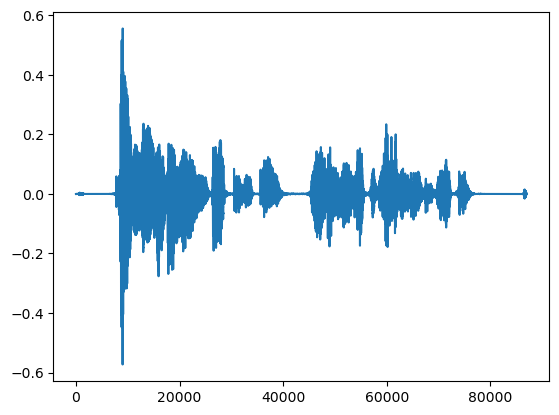

In [33]:
plt.plot(audio_out.cpu().numpy().flatten(), label='real')

In [34]:
torchaudio.save('audio_test_6.wav', audio_out.cpu(), sample_rate=24000, encoding='PCM_S', bits_per_sample=16)

In [82]:
data = pd.read_csv('../torres_test/data.csv').sample(frac=1)
data['kokoro_path'] = data['audio_path'].str.replace('agamemnon_vctk/VCTK', 'kokoro_audios', regex=False)

In [83]:
wav_r, sr = torchaudio.load(data['audio_path'].iloc[0])
wav_r = convert_audio(wav_r, sr, 24000, 1) 

In [84]:
wav_k, sr = torchaudio.load(data['kokoro_path'].iloc[0])
wav_k = convert_audio(wav_k, sr, 24000, 1) 

In [85]:
data['audio_path'].iloc[0]

'/data/anasynth_nonbp/dtorres/agamemnon_vctk/VCTK/VCTK-speaker-p318-female/audio/wav/288.flac'

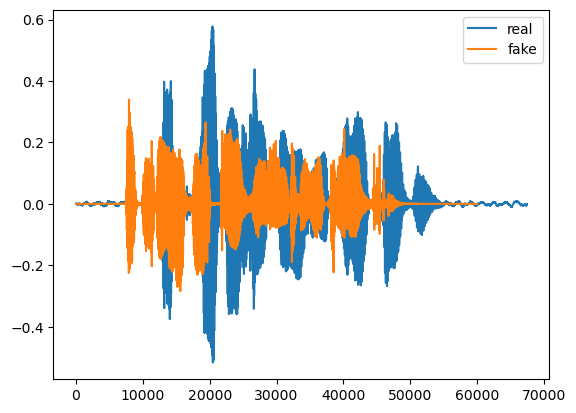

In [88]:
plt.plot(wav_r.cpu().numpy().flatten(), label='real')
plt.plot(wav_k.cpu().numpy().flatten(), label='fake')
plt.legend()

In [87]:
torchaudio.save('audio_r.wav', wav_r.cpu(), sample_rate=24000, encoding='PCM_S', bits_per_sample=16)
torchaudio.save('audio_k.wav', wav_k.cpu(), sample_rate=24000, encoding='PCM_S', bits_per_sample=16)

In [91]:
features, discrete_code = wavtokenizer.encode_infer(wav_k.to(device), bandwidth_id=bandwidth_id)
audio_out = wavtokenizer.decode(features, bandwidth_id=bandwidth_id) 

In [92]:
discrete_code ## when it's 3568 it usually means it's silence

tensor([[[2754, 3568, 1883, 1883, 3568, 1883, 3568, 3568, 3568, 3568, 3568,
          3568, 3568, 3754, 1300, 3296,  959, 1718, 1473, 1051, 1041,  484,
           628, 4026, 3837, 1122, 4061, 2392, 3675, 1007, 1689, 1026, 1871,
            81, 1011, 1724, 3980, 1137, 3518, 3824, 1679, 3016, 2296, 2416,
          2182,  989,  406,   20, 2776,  852, 3271, 2986,  455, 1971,  786,
          3624, 2859,  132,  161, 1437, 3874, 1828,   46, 3279, 1032,  825,
          2727, 2470, 1200, 4045, 3549, 3700, 3912, 3327, 1200,  250, 2964,
           878, 1808,  101, 1680, 1427, 1488, 3471, 3860,  937,  340, 3376,
          1484, 2298, 2056, 3295, 1241, 2297, 3551,  919,  411,   86, 3774,
          2638,  928, 3456,  555, 3806, 3445, 3823, 3207, 3912, 1032, 3388,
          2217, 3769, 3075, 1945, 2292, 2547, 2098, 2620,  200,  801, 2419,
          1930, 1625, 2084, 3393, 3287,  684,  431, 2355, 1521, 3766,  543,
          3409, 3051, 2371, 1675, 2344, 2077,  360, 3613, 3882, 1063,  147,
          32

In [93]:
audio_out = wavtokenizer.decode(features, bandwidth_id=bandwidth_id) 

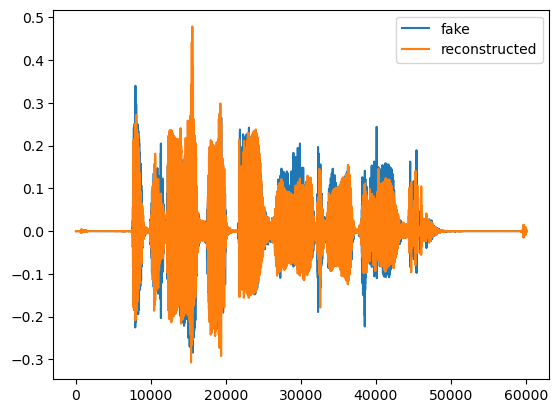

In [94]:
plt.plot(wav_k.cpu().numpy().flatten(), label='fake')
plt.plot(audio_out.cpu().numpy().flatten(), label='reconstructed')
plt.legend()

In [95]:
torchaudio.save('audio_test.wav', audio_out.cpu(), sample_rate=24000, encoding='PCM_S', bits_per_sample=16)

In [98]:
torch.load('/data/anasynth_nonbp/dtorres/agamemnon_vctk/VCTK/VCTK-speaker-p233-female/features/wavtokenizer_medium_75/209.pth')

tensor([2754, 3568, 1883, 1883, 3568, 1883, 3568, 3568, 3568, 3568, 3568, 3568,
        3568, 1883, 1300, 4031,  959, 1051, 1473, 1442,  236,  938, 2388, 1933,
        1557, 4045, 2600, 2026, 2884,  414, 1026, 1121, 1375, 2611, 1026, 1736,
        2008, 2643,  594, 2832, 1640, 3553, 3994, 1502, 3841, 2508, 2933,  872,
        1473, 1903, 1198, 3050, 3952,  578,  758, 2554, 4081, 3936, 3072, 3213,
          72, 1218,  935,  211,   37,  498, 1964, 1145,  156, 1331, 3830, 3421,
        1331, 2008, 1058,  843, 1954, 3071,  419, 2523, 2269, 1354, 2627, 3309,
        3357,  188,  698, 3429, 2792, 1624, 1778, 2269, 3905, 3060,  390,  919,
         411,  857, 2347, 1416, 2967, 3290, 2397, 1180, 1344, 2910, 2137, 1085,
        2994, 2001, 1151, 3146, 4079,  769, 3142, 1125,  338,  927, 1721, 1842,
         599, 2943, 2100, 1951, 3094,  860,  887, 1721, 3508,  603, 2147, 2147,
        1504, 1504,  477, 3689, 2147,  917,   52, 3311,  849, 2298, 4024,  908,
        3019, 1121,  965,  235,  576,  5